In [58]:
%%writefile dtrsv.cpp

#include <stdio.h>
#include <stdlib.h>
#include <vector>
#include <chrono>
#include <cmath>
#include <cblas.h>

void random_vector(double* x, int n){
    for(int i = 0; i < n; ++i){
        x[i] = (double)rand() / RAND_MAX;
    }
}

void random_lower_triangular_matrix(double* A, int n){
    // Set A = zeros
    // Reset A
    for(int i = 0; i < n; ++i){
        for(int j = 0; j < i; ++j){
            A[i*n + j] = 0.0;
        }
    }
    // Randomly set A
    for(int i = 0; i < n; ++i){
        for(int j = 0; j < i; ++j){
            A[i*n + j] = (double)rand() / RAND_MAX;
        }
        // Diagonal elements should be non-zero
        A[i*n + i] = (double)rand() / RAND_MAX + 1.0;
    }
}

// Solve Ly = b
void naive_dtrsv(const double* L, const double* b, double* y, int n){
    for(int i = 0; i < n; ++i){
        y[i] = b[i];
        for(int j = 0; j < i; ++j){
            y[i] -= L[i*n + j] * y[j];
        }
        y[i] /= L[i*n + i];
    }
}

// b = A * x
void matvec(const double* A, const double* x, double* y, int n){
    for(int i = 0; i < n; ++i){
        y[i] = 0.0;
        for(int j = 0; j < n; ++j){
            y[i] += A[i*n + j] * x[j];
        }
    }
}

void assert_vector_equal(const double* x, const double* y, int n, double tolerance){
    for(int i = 0; i < n; ++i){
        if(std::fabs(x[i] - y[i]) > tolerance){
            printf("Error: x[%d] = %f, y[%d] = %f\n", i, x[i], i, y[i]);
            exit(1);
        }
    }
}

void test_cblas_dtrsv(double *L, double *b, double *u, int n){
    std::vector<double> y(n);
    // copy b to y
    for(int i = 0; i < n; ++i){
        y[i] = b[i];
    }
    cblas_dtrsv(CblasRowMajor, CblasLower, CblasNoTrans, CblasNonUnit, n, L, n, y.data(), 1);

    // Check correctness
    assert_vector_equal(u, y.data(), n, 1e-3);
}

int main(){
    FILE* fp = fopen("dtrsv.csv", "w");
    std::vector<int> N = {100, 200, 300, 400, 500, 600, 700, 800, 1000};
    const int num_repeats = 5;

    fprintf(fp, "N,algorithm,time_secs\n");
    printf("N,dtrsv_naive,dtrsv\n");
    for(int n : N){        
        // Allocate memory
        std::vector<double> L(n * n);
        std::vector<double> y(n);
        std::vector<double> b(n);
        std::vector<double> u(n);

        // Generate random matrix and vector
        random_lower_triangular_matrix(L.data(), n);
        random_vector(u.data(), n);
        matvec(L.data(), u.data(), b.data(), n); // b = L * u

        // Test dtrsv_naive
        auto tic = std::chrono::high_resolution_clock::now();
        for(int i = 0; i < num_repeats; ++i){
            // Solve Ly = b
            naive_dtrsv(L.data(), b.data(), y.data(), n);
        }
        auto toc = std::chrono::high_resolution_clock::now();
        double time_secs = std::chrono::duration<double>(toc - tic).count();
        time_secs /= num_repeats; // average time
        fprintf(fp, "%d,%s,%f\n", n, "naive_dtrsv",time_secs);        
        printf("%d,%s,%f\n", n, "naive_dtrsv",time_secs);

        // Check correctness
        assert_vector_equal(u.data(), y.data(), n, 1e-3);

        test_cblas_dtrsv(L.data(), b.data(), u.data(), n);

        // Test dtrsv blas
        tic = std::chrono::high_resolution_clock::now();        
        for(int i = 0; i < num_repeats; ++i){
            cblas_dtrsv(CblasRowMajor, CblasLower, CblasNoTrans, CblasNonUnit, n, L.data(), n, b.data(), 1);
        }
        toc = std::chrono::high_resolution_clock::now();
        time_secs = std::chrono::duration<double>(toc - tic).count();
        time_secs /= num_repeats; // average time
        fprintf(fp, "%d,%s,%f\n", n, "cblas_dtrsv",time_secs);
        printf("%d,%s,%f\n", n, "cblas_dtrsv",time_secs);
    }
}

Overwriting dtrsv.cpp


In [59]:
!g++ dtrsv.cpp -lm -lblas -o dtrsv.exe
!./dtrsv.exe

N,dtrsv_naive,dtrsv
100,naive_dtrsv,0.000017
100,cblas_dtrsv,0.000004
200,naive_dtrsv,0.000067
200,cblas_dtrsv,0.000017
300,naive_dtrsv,0.000150
300,cblas_dtrsv,0.000039
400,naive_dtrsv,0.000228
400,cblas_dtrsv,0.000054
500,naive_dtrsv,0.000350
500,cblas_dtrsv,0.000084
600,naive_dtrsv,0.000502
600,cblas_dtrsv,0.000121
700,naive_dtrsv,0.000684
700,cblas_dtrsv,0.000165
800,naive_dtrsv,0.000900
800,cblas_dtrsv,0.000217
1000,naive_dtrsv,0.001398
1000,cblas_dtrsv,0.000340


In [60]:
import pandas as pd

df = pd.read_csv("dtrsv.csv")
df.head()

,N,algorithm,time_secs
0,100,naive_dtrsv,0.000017
1,100,cblas_dtrsv,0.000004
2,200,naive_dtrsv,0.000067
3,200,cblas_dtrsv,0.000017
4,300,naive_dtrsv,0.000150


In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

# define whitegrid style
sns.set_style("whitegrid")

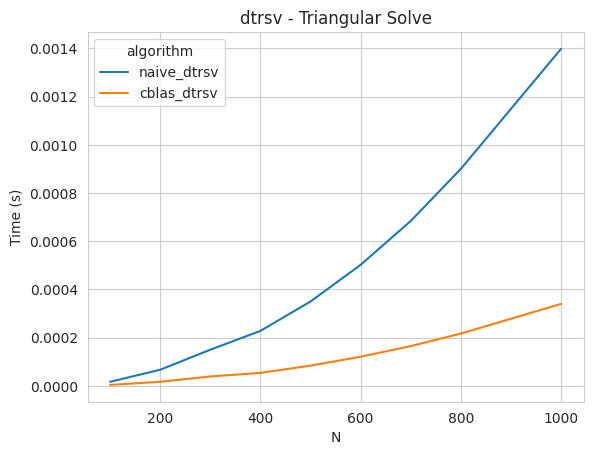

In [62]:
# plot x='N', y='time_secs', hue='algorithm'
sns.lineplot(x='N', y='time_secs', hue='algorithm', data=df)
plt.ylabel('Time (s)')
plt.title('dtrsv - Triangular Solve')
plt.show()


Text(0.5, 1.0, 'dtrsv - Speedup')

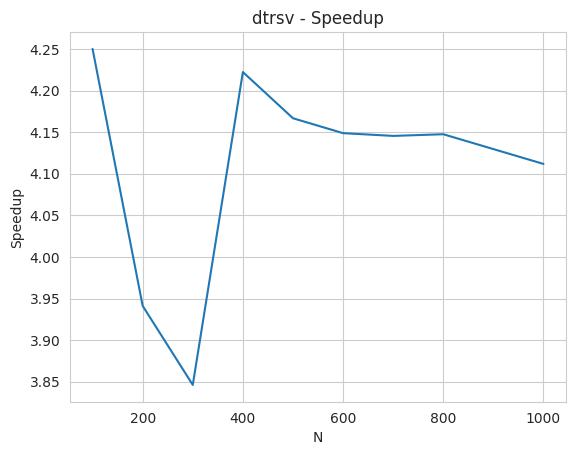

In [68]:
# Create speedup plot
df_naive = df[df['algorithm'] == 'naive_dtrsv']
df_cblas = df[df['algorithm'] == 'cblas_dtrsv']
df_speedup = pd.merge(df_naive, df_cblas, on='N')
df_speedup['speedup'] = df_speedup['time_secs_x'] / df_speedup['time_secs_y']

# plot x='N', y='speedup'
sns.lineplot(x='N', y='speedup', data=df_speedup)
plt.ylabel('Speedup')
plt.title('dtrsv - Speedup')

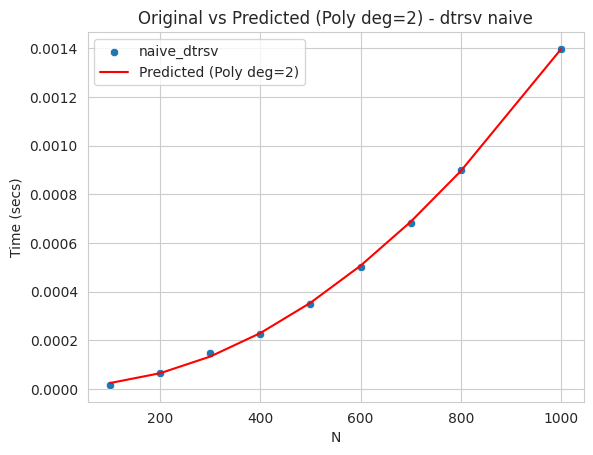

In [73]:
# Fit a polynomial (degree=2) model to the data
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

X = df_naive['N'].values.reshape(-1, 1)
y = df_naive['time_secs'].values.reshape(-1, 1)

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

model = LinearRegression()
model.fit(X_poly, y)
y_poly_pred = model.predict(X_poly)

# Plot the original data and the polynomial regression predictions using seaborn
sns.scatterplot(x='N', y='time_secs', data=df_naive, label='naive_dtrsv')
sns.lineplot(x=df_naive['N'], y=y_poly_pred.flatten(), color='red', label='Predicted (Poly deg=2)')

plt.xlabel('N')
plt.ylabel('Time (secs)')
plt.title('Original vs Predicted (Poly deg=2) - dtrsv naive')
plt.legend()
plt.show()
